# EX6: Improving Regression with Polynomial Features and Regularization

**Objective**: Build on EX5 Linear Regression findings to improve the insurance charges model by:
1. Adding polynomial components and retraining the best implementation from EX5
2. Implementing Lasso, Ridge, and Elastic Net regularization and comparing results

**Dataset**: insurance.csv (medical insurance charges)

## 1. Load the dataset and apply EX5-style preparation

From EX5 we know:
- **Target**: `charges` (dependent variable)
- **Features**: age, sex, bmi, children, smoker, region (independent)
- **Categoricals**: sex, smoker, region → encode with `pd.get_dummies()`
- **Charges** is right-skewed; we use the same preprocessing as EX5.

In [1]:
import pandas as pd
import numpy as np
import os

# Load insurance.csv (local path or download from URL)
data_path = 'data/insurance.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    url = 'https://raw.githubusercontent.com/pycaret/pycaret/master/datasets/insurance.csv'
    df = pd.read_csv(url)

print('Shape:', df.shape)
df.head(10)

Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [2]:
# Prepare features and target (EX5 approach: dummy coding for categoricals)
target = 'charges'
y = df[target]
X_raw = df.drop(columns=[target])

# Dummy coding for categorical variables (as in EX5)
X_encoded = pd.get_dummies(X_raw, dtype=float)

print('Features after encoding:', list(X_encoded.columns))
X_encoded.head()

Features after encoding: ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split (reproducible)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Scale features (important for regularization and polynomial terms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Train size:', len(y_train), '| Test size:', len(y_test))

Train size: 1070 | Test size: 268


## 2. Baseline: Best implementation from EX5 (Linear Regression on scaled features)

We use ordinary least squares linear regression on the encoded and scaled features as the baseline to improve upon.

In [4]:
lr_baseline = LinearRegression()
lr_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = lr_baseline.predict(X_test_scaled)

mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print('Baseline Linear Regression (EX5-style)')
print('  Test MSE:  ', round(mse_baseline, 2))
print('  Test RMSE: ', round(np.sqrt(mse_baseline), 2))
print('  Test R²:   ', round(r2_baseline, 4))

Baseline Linear Regression (EX5-style)
  Test MSE:   33596915.85
  Test RMSE:  5796.28
  Test R²:    0.7836


/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


## 3. Add polynomial features and retrain

We add polynomial components (degree=2) to capture non-linear relationships, then fit the same linear regression. We fit PolynomialFeatures on the scaled training data and transform both train and test.

In [5]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Scale polynomial features to avoid ill-conditioning and overflow (fixes RuntimeWarning)
scaler_poly = StandardScaler()
X_train_poly = scaler_poly.fit_transform(X_train_poly)
X_test_poly = scaler_poly.transform(X_test_poly)

print('Original features:', X_train_scaled.shape[1])
print('After polynomial (degree=2):', X_train_poly.shape[1])

Original features: 11
After polynomial (degree=2): 77


In [6]:
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print('Linear Regression with Polynomial Features (degree=2)')
print('  Test MSE:  ', round(mse_poly, 2))
print('  Test RMSE: ', round(np.sqrt(mse_poly), 2))
print('  Test R²:   ', round(r2_poly, 4))

Linear Regression with Polynomial Features (degree=2)
  Test MSE:   20712805.99
  Test RMSE:  4551.13
  Test R²:    0.8666


/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


## 4. Regularized models: Lasso, Ridge, and Elastic Net

We train Lasso (L1), Ridge (L2), and Elastic Net (L1+L2) on the **polynomial** features to control overfitting and compare performance. We use a moderate regularization strength (alpha) for comparison; you can tune via cross-validation.

In [11]:
alpha = 1.0   # regularization strength (can tune with GridSearchCV)
l1_ratio = 0.5  # for Elastic Net: 0.5 = equal L1 and L2

ridge = Ridge(alpha=alpha)
lasso = Lasso(alpha=alpha)
elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

ridge.fit(X_train_poly, y_train)
lasso.fit(X_train_poly, y_train)
elastic.fit(X_train_poly, y_train)

y_pred_ridge = ridge.predict(X_test_poly)
y_pred_lasso = lasso.predict(X_test_poly)
y_pred_elastic = elastic.predict(X_test_poly)

/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  retur

In [8]:
def report(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MSE': mse, 'RMSE': np.sqrt(mse), 'R²': r2}

results = [
    report('Baseline (Linear Regression)', y_test, y_pred_baseline),
    report('Polynomial + Linear Regression', y_test, y_pred_poly),
    report('Polynomial + Ridge', y_test, y_pred_ridge),
    report('Polynomial + Lasso', y_test, y_pred_lasso),
    report('Polynomial + Elastic Net', y_test, y_pred_elastic),
]

results_df = pd.DataFrame(results)
results_df

,Model,MSE,RMSE,R²
0,Baseline (Linear Regression),3.359692e+07,5796.284659,0.783593
1,Polynomial + Linear Regression,2.071281e+07,4551.132385,0.866583
2,Polynomial + Ridge,2.071349e+07,4551.207365,0.866579
3,Polynomial + Lasso,2.070777e+07,4550.579346,0.866616
4,Polynomial + Elastic Net,2.411828e+07,4911.036215,0.844648


## 5. Compare results (summary table and bar plot)

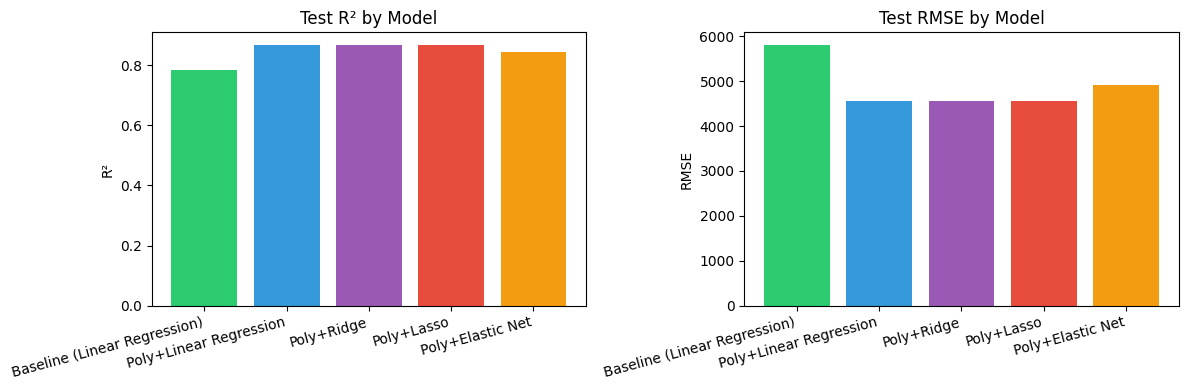

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

models = results_df['Model'].tolist()
x_pos = np.arange(len(models))

axes[0].bar(x_pos, results_df['R²'], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'])
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([m.replace('Polynomial + ', 'Poly+') for m in models], rotation=15, ha='right')
axes[0].set_ylabel('R²')
axes[0].set_title('Test R² by Model')

axes[1].bar(x_pos, results_df['RMSE'], color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([m.replace('Polynomial + ', 'Poly+') for m in models], rotation=15, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Test RMSE by Model')

plt.tight_layout()
plt.show()

## 6. Optional: Tuning regularization strength (alpha)

Below we quickly compare different alpha values for Ridge on polynomial features to show how regularization affects performance.

/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ramyaramesh/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  retur

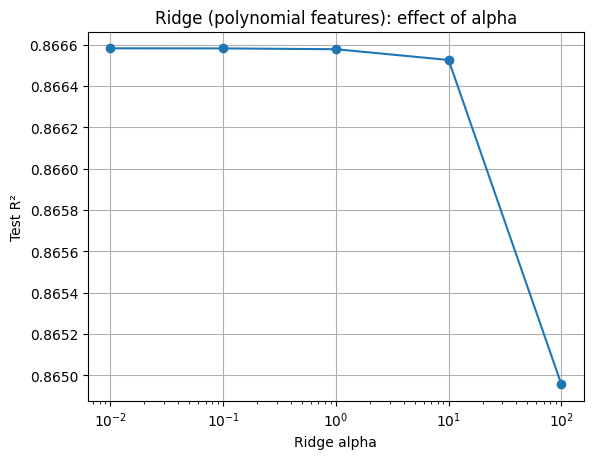

In [13]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_scores = []
for a in alphas:
    m = Ridge(alpha=a).fit(X_train_poly, y_train)
    r2 = r2_score(y_test, m.predict(X_test_poly))
    ridge_scores.append(r2)

plt.plot(alphas, ridge_scores, 'o-')
plt.xscale('log')
plt.xlabel('Ridge alpha')
plt.ylabel('Test R²')
plt.title('Ridge (polynomial features): effect of alpha')
plt.grid(True)
plt.show()

## 7. Summary of findings

See **SUMMARY.md** in this folder for a written summary of:
- Impact of polynomial features vs baseline
- Comparison of Lasso, Ridge, and Elastic Net
- Recommendations for the insurance charges model